In [107]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
import plotly.graph_objects as go
import sklearn.preprocessing 
import sklearn.linear_model
from sklearn.metrics import mean_squared_error
import sklearn.model_selection
from sklearn.feature_selection import RFE

In [108]:
df.head

<bound method NDFrame.head of      X  Y      FFMC       DMC        DC       ISI      temp        RH  \
0    7  5 -1.224301 -1.033680 -2.069657 -0.961643 -1.830214  0.420987   
1    7  4 -0.081485 -0.917847  0.026623 -0.567640 -0.136000 -0.696894   
2    7  4 -0.081485 -0.813346  0.091539 -0.567640 -0.723789 -0.696894   
3    8  6  0.204219 -0.944287 -2.130926 -0.001262 -1.812926  3.277796   
4    8  6 -0.419136 -0.717658 -2.040846  0.146489 -1.277001  3.402005   
..  .. ..       ...       ...       ...       ...       ...       ...   
511  8  6 -2.419064 -0.649669  0.013858 -1.749647  1.558213 -0.572685   
512  4  3 -2.419064 -0.649669  0.013858 -1.749647  1.558213 -0.758999   
514  7  4 -2.419064 -0.649669  0.013858 -1.749647  0.417212  1.600973   
515  1  4  0.905492  0.474662 -0.171772  0.565117  1.177879 -0.137954   
516  6  3 -2.964499 -1.325779 -2.024435 -1.946649 -1.207850 -0.821103   

         wind      rain  ...  month_oct  month_sep  day_fri  day_mon  day_sat  \
0    1.49028

In [109]:
df = pd.read_csv('forestfires.csv')
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# EDA

### Типы данных столбцов

In [110]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

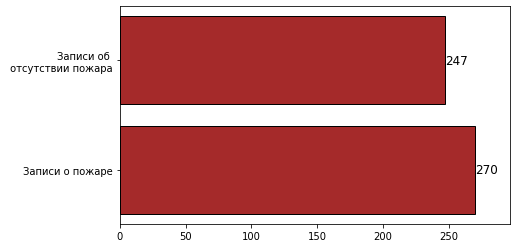

In [111]:
plt.figure(figsize=(7,4))
fire_counts = df[df['area'] != 0].count()[0]
nofire_counts = df[df['area'] == 0].count()[0]

bars = plt.barh(['Записи о пожаре', 'Записи об \n отсутствии пожара'], 
               [fire_counts, nofire_counts], 
               color='brown', edgecolor='black') #height = 0.)
plt.xlim(0, max(fire_counts, nofire_counts) * 1.1)  # умножаем на 1.2 для дополнительного пространства
plt.bar_label(bars, fontsize=12)
plt.show()

### Чаще всего пожары случаются в регионах с координатами долготы 2, 4, в средней полосе

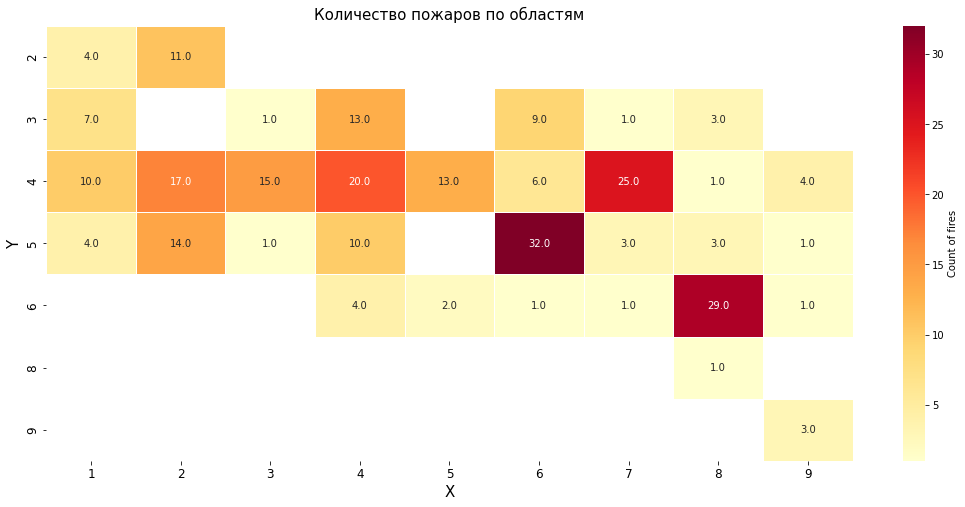

In [112]:
def XY(row):
    return (str(row['X']) + '|' + str(row['Y']))

vis = df
vis['X|Y'] = vis.apply(XY, axis = 1)
vis = vis[vis['area']!=0]
values = vis['X|Y'].to_list()
index = vis['area'].to_list()
size = pd.Series(values, index).value_counts().sort_index()

X, Y = [], []
for i in size.index:
    X.append(int(i.split('|')[0]))
    Y.append(int(i.split('|')[1]))
    
data = pd.DataFrame({'X': X, 'Y': Y, 'Count of fires': size})
heatmap_data = pd.pivot_table(data, values='Count of fires', index='Y', columns='X')

plt.figure(figsize = (14,8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Count of fires'},
            xticklabels=1, yticklabels=1)

plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Количество пожаров по областям', fontsize = 15)
plt.subplots_adjust(left=0, right=1)
plt.show()
df.drop('X|Y', axis= 1 , inplace= True )

### Наиболее часто возгорания происходят в августе и сентябре

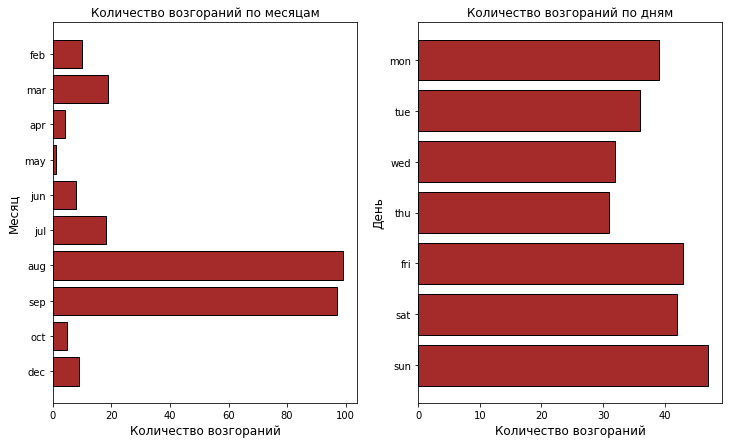

In [113]:
month = ['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'dec']
month_number = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

mo = df[df['area'] != 0]['month'].value_counts()
mo = mo.rename(index={month[i]:month_number[i] for i in range(len(month))}).sort_index(ascending=False)
mo = mo.rename(index={month_number[i]:month[i] for i in range(len(month))})

days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
day = df[df['area'] != 0]['day'].value_counts()
day = day.rename(index={days[i]:(i+1) for i in range(len(days))}).sort_index(ascending=False)
day = day.rename(index={(i+1):days[i] for i in range(len(days))})

plt.figure(figsize = (12,7))
m = plt.subplot(1,2,1)
m.barh(mo.index, mo, color='brown', edgecolor = 'black')
plt.title('Количество возгораний по месяцам')
plt.xlabel('Количество возгораний', fontsize=12)
plt.ylabel('Месяц', fontsize=12)

d = plt.subplot(1,2,2)
d.barh(day.index, day, color='brown', edgecolor = 'black')
plt.title('Количество возгораний по дням')
plt.xlabel('Количество возгораний', fontsize=12)
plt.ylabel('День', fontsize=12)

plt.show()

### Частотные распределения погодных признаков имеют смещения, можно попробовать нормализацию

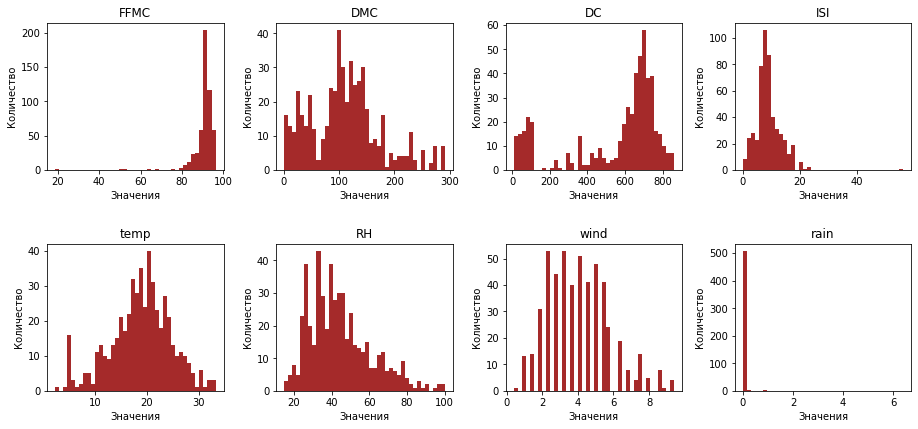

In [114]:
c = [column for column in df][4:12]
plt.figure(figsize=(15,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(df.iloc[:, [i+4]],bins = 40, color = 'brown')
    plt.title(c[i])
    plt.xlabel('Значения')
    plt.ylabel('Количество')
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.5)
plt.show()

#### Обработаем выбросы в FFMC, ISI, rain

In [115]:
#выбросы признака FFMC
df.drop(df.loc[df['FFMC'] < 60].index, inplace=True)

#выбросы признака ISI
df.drop(df.loc[df['ISI'] > 25].index, inplace=True)

#выбросы признака rain
df.drop(df.loc[df['rain'] > 2].index, inplace=True)

### Корреляции признаков

In [116]:
df_new = df.iloc[:, [0,1,4,5,6,7,8,9,10,11,12,3]]
corr = df_new.corr()
corr.style.background_gradient(cmap='YlOrRd')

C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_29900/3819992626.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new.corr()


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.540601,-0.058633,-0.053077,-0.082975,-0.022271,-0.057929,0.088910,0.020187,0.074469,0.063750
Y,0.540601,1.000000,-0.041551,0.008633,-0.099741,-0.020018,-0.022147,0.056480,-0.017534,0.030201,0.045222
FFMC,-0.058633,-0.041551,1.000000,0.459669,0.416740,0.687777,0.489537,-0.223624,-0.095441,0.063613,0.043234
DMC,-0.053077,0.008633,0.459669,1.000000,0.683221,0.337878,0.462365,0.093002,-0.111651,0.092075,0.072061
DC,-0.082975,-0.099741,0.416740,0.683221,1.000000,0.284641,0.495264,-0.026705,-0.214218,0.047710,0.048332
ISI,-0.022271,-0.020018,0.687777,0.337878,0.284641,1.000000,0.421137,-0.121606,0.109638,0.070992,0.011555
temp,-0.057929,-0.022147,0.489537,0.462365,0.495264,0.421137,1.000000,-0.520966,-0.239712,0.027741,0.097208
RH,0.088910,0.056480,-0.223624,0.093002,-0.026705,-0.121606,-0.520966,1.000000,0.081182,0.171109,-0.074032
wind,0.020187,-0.017534,-0.095441,-0.111651,-0.214218,0.109638,-0.239712,0.081182,1.000000,0.129831,0.012048
rain,0.074469,0.030201,0.063613,0.092075,0.047710,0.070992,0.027741,0.171109,0.129831,1.000000,-0.019421


### Площадь возгорания имеет большой разброс

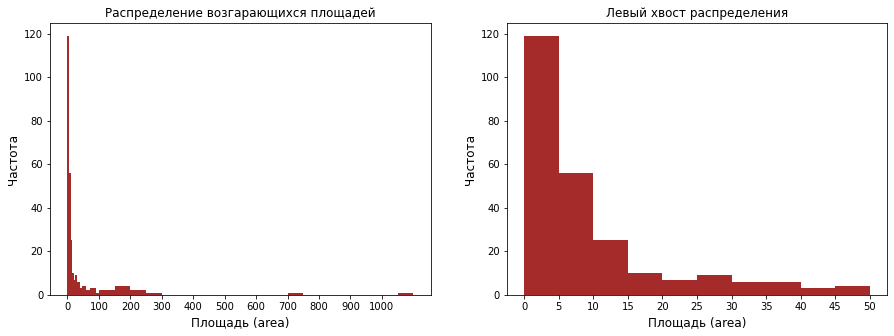

In [117]:
area = df[df['area']!=0]['area']
bins_5 = [5*i for i in range(11)]
bins_10 = [bins_5[-1] + 10*i for i in range(1, 6)]
bins_50 = [bins_10[-1] + 50*i for i in range(1, 21)]
bins = bins_5 + bins_10 + bins_50

area_50 = area[area <= 50]

plt.rcParams ['figure.figsize'] = [15, 5]

plt.subplot(1,2,1)
plt.hist(area, bins = bins, color='brown')
plt.xticks(np.arange(0, 1100, step=100))
plt.title('Распределение возгарающихся площадей')
plt.xlabel('Площадь (area)', fontsize = 12)
plt.ylabel('Частота', fontsize = 12)

plt.subplot(1,2,2)
plt.hist(area_50, bins = [5*i for i in range(11)], color = 'brown')
plt.xticks(np.arange(0,51,step=5))
plt.title('Левый хвост распределения')
plt.xlabel('Площадь (area)', fontsize = 12)
plt.ylabel('Частота', fontsize = 12)

plt.show()

#### Обработаем выбросы

In [118]:
df.drop(df.loc[df['area'] > 50].index, inplace=True)

In [119]:
df.shape

(488, 13)

### Нормализация признаков

In [120]:
from sklearn.preprocessing import StandardScaler, RobustScaler

standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

columns_standard_scale = ['FFMC', 'ISI', 'temp', 'RH', 'wind', 'rain']
column_area = ['area']
columns_robust_scale = ['DMC', 'DC']

df[columns_standard_scale] = standard_scaler.fit_transform(df[columns_standard_scale])
df[columns_robust_scale] = robust_scaler.fit_transform(df[columns_robust_scale])

scaler_area = StandardScaler()
df[column_area] = scaler_area.fit_transform(df[column_area])

# Training

#### One Hot Encoding, Mixing and Splitting

In [121]:
#OneHotEncoding
ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform='pandas')

ohetransform_m = ohe.fit_transform(df[['month']])
df = pd.concat([df, ohetransform_m], axis = 1).drop(columns='month')

ohetransform_d = ohe.fit_transform(df[['day']])
df = pd.concat([df, ohetransform_d], axis = 1).drop(columns='day')

In [122]:
#Меняем порядок столбцов
area = df['area']
df = df.drop('area', axis=1)

df.insert(df.shape[1], 'area', area)

In [123]:
#Замешиваем датасет
df_sample = df.sample(frac=1, random_state=1) #перемешиваем

In [124]:
#Делим на train и test
cut = int(.75*len(df))
train = df_sample.iloc[:cut] #тренировочный датасет
X_train, Y_train = [train.iloc[:, [i for i in range(29)]], train.iloc[:, [29]]] #тренировочные данные

test = df_sample.iloc[cut:] #тестовый датасет
X_test, Y_test = [test.iloc[:, [i for i in range(29)]], test.iloc[:, [29]]] #тестовые данные

### Training

#### Linear model

In [125]:
linear = sklearn.linear_model.LinearRegression()
linear.fit(X_train, Y_train)

LinearRegression()

In [128]:
linear_prediction = linear.predict(X_test)

Y_test_original = pd.DataFrame(scaler_area.inverse_transform(Y_test), columns=Y_test.columns)
linear_prediction_original = pd.DataFrame(scaler_area.inverse_transform(linear_prediction.reshape(-1, 1)), columns=Y_test.columns)

linear_rmse = np.sqrt(mean_squared_error(linear_prediction_original, Y_test_original))

print('RMSE:', linear_rmse)

RMSE: 7.640693161616943


#### Score on Cross-Validation

In [130]:
linear_cv = sklearn.linear_model.LinearRegression()
cv = sklearn.model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)

score = abs(sklearn.model_selection.cross_val_score(estimator = linear_cv,
                                                    X = df_sample.iloc[:, [i for i in range(29)]], 
                                                    y = df_sample.iloc[:, [29]],
                                                    cv = cv,
                                                    scoring = 'neg_mean_squared_error'))
mean_cv_score = np.mean(np.sqrt(score))
print('Средний скор на кросс-валидации без обратного преобразования: ', mean_cv_score)

Средний скор на кросс-валидации без обратного преобразования:  1.0407063565310959


### Отбор признаков с помощью RFE

In [131]:
#ранжируем фичи про влиянию на предсказания
linear = sklearn.linear_model.LinearRegression()
selector = RFE(linear, n_features_to_select=10, step=1)
selector = selector.fit(X_test, Y_test)
print('Значение i-го элемента характеризует влияние i-го признака, 10 выбраны приоритетными:', '\n', 
      selector.ranking_)

Значение i-го элемента характеризует влияние i-го признака, 10 выбраны приоритетными: 
 [16 15  7 10  1  3 11 13 17 12  1  1  1  1 18  1  1  9 20 19  4  2 14  6
  5  1  8  1  1]


In [132]:
#отбираем 10 наиболее влиятельных признаков
threshold_level = 1
unnecessary = [index for index, value in enumerate(selector.ranking_) if value > threshold_level]
X_test.drop(X_test.columns[[i for i in unnecessary]], axis = 1, inplace = True)
X_train.drop(X_train.columns[[i for i in unnecessary]], axis = 1, inplace = True)

C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_29900/1973307075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(X_test.columns[[i for i in unnecessary]], axis = 1, inplace = True)
C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_29900/1973307075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(X_train.columns[[i for i in unnecessary]], axis = 1, inplace = True)


In [134]:
#обучаем модель с меньшим кол-вом признаков
new_linear = sklearn.linear_model.LinearRegression()
new_linear.fit(X_train, Y_train)

new_linear_prediction = new_linear.predict(X_test)
new_linear_prediction = pd.DataFrame(scaler_area.inverse_transform(new_linear_prediction.reshape(-1, 1)), columns=Y_test.columns)

new_rmse = np.sqrt(mean_squared_error(new_linear_prediction, Y_test))
print('RMSE после обратного логарифмического преобразования и отбора 10 лучших признаков:', new_rmse)

RMSE после обратного логарифмического преобразования и отбора 10 лучших признаков: 5.498116691691435


In [137]:
print('RMSE классической регрессии до выделения ключевых признаков:', linear_rmse.round(5))
print('RMSE классической регрессии после выделения ключевых признаков:', new_rmse.round(5),'\n')
print('Вывод: изменение ', round(abs(linear_rmse.round(5) - new_rmse.round(5)),5), ' наблюдаем улучшение метрики')

RMSE классической регрессии до выделения ключевых признаков: 7.64069
RMSE классической регрессии после выделения ключевых признаков: 5.49812 

Вывод: изменение  2.14257  наблюдаем улучшение метрики


In [138]:
print('10 наиболее влияющих на предсказание признаков:', '\n', [i for i in X_train.columns])

10 наиболее влияющих на предсказание признаков: 
 ['DC', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun', 'day_sun', 'day_tue', 'day_wed']


In [139]:
print('Среднее значение предсказанной величины после обратного логарифмического преобразования: ', 
      round(new_linear_prediction.mean()[0],4))
print('Следовательно, модель чаще предсказывает небольшие возгарания')

Среднее значение предсказанной величины после обратного логарифмического преобразования:  5.0221
Следовательно, модель чаще предсказывает небольшие возгарания


### Lasso & Ridge

In [140]:
train = df_sample.iloc[:cut] #тренировочный датасет
X_train, Y_train = [train.iloc[:, [i for i in range(29)]], train.iloc[:, [29]]] #тренировочные данные

test = df_sample.iloc[cut:] #тестовый датасет
X_test, Y_test = [test.iloc[:, [i for i in range(29)]], test.iloc[:, [29]]] #тестовые данные

#### Ridge

In [141]:
ridge = sklearn.linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)

Ridge()

In [144]:
ridge_prediction = ridge.predict(X_test)

Y_test_original = pd.DataFrame(scaler_area.inverse_transform(Y_test), columns=Y_test.columns)
ridge_prediction_original = pd.DataFrame(scaler_area.inverse_transform(ridge_prediction.reshape(-1, 1)), columns=Y_test.columns)

ridge_rmse = np.sqrt(mean_squared_error(ridge_prediction_original, Y_test_original))
print('RMSE:', ridge_rmse)

RMSE: 7.641444725620162


In [145]:
print('Среднее значение предсказанной величины: ', 
      round(ridge_prediction_original.mean()[0],4))
print('Следовательно, модель чаще предсказывает небольшие возгарания')

Среднее значение предсказанной величины:  5.1395
Следовательно, модель чаще предсказывает небольшие возгарания


#### Lasso

In [146]:
lasso = sklearn.linear_model.Lasso(alpha=1.0)
lasso.fit(X_train, Y_train)

Lasso()

In [147]:
lasso_prediction = lasso.predict(X_test)

lasso_prediction_original = pd.DataFrame(scaler_area.inverse_transform(lasso_prediction.reshape(-1, 1)), columns=Y_test.columns)

lasso_rmse = np.sqrt(mean_squared_error(lasso_prediction, Y_test_original))
print('RMSE:', lasso_rmse)

RMSE: 8.645167108756514


# Выводы

В процессе исследовательского анализа данных были удалены выбросы.  
Корреляционный анализ показал, что проблема мультиколлинеарности признаков вряд ли сделает предсказания модели хуже. Последнюю гипотезу подтвердило обучение моделей Lasso & Ridge, которые показали примерно такие же результаты, как и классическая линейная регрессия.  
  
Из-за того, что объектов с таргетом AREA > 50 в датасете немного, эти объекты были отброшены, после было применено сжимающее отображение, которое позволило собрать данные в левом хвосте с меньшей дисперсией.  
  
Всего было обучено 4 модели: линейная регрессия, линейная регрессия с отбором 10 наиболее влияющих на предсказания первой признаков, Lasso & Ridge регрессии

Значения RMSE после обратного логарифмического преобразования:  
<b>Классическая линейная регрессия:</b> 7.641  
<b>Классическая линейная регрессия после выделения 10 ключевых признаков:</b> 5.498 
<b>Ridge-регрессия:</b> 7.641
<b>Lasso-регрессия:</b> 8.645

### Качество предсказаний моделей находится в диапазоне от 7.64 до 8.01, с такими результатами леса будут гореть и довольно сильно, к сожалению